
# **Сегментация изображений с автопилота**

**Подготовка данных**

In [ ]:
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization 
from tensorflow.keras import backend as K 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import utils 
from google.colab import files 
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing import image 
import numpy as np 
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import time
import random
import os 
from PIL import Image 


In [ ]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

In [ ]:
# Глобальные параметры
img_width = 176  
img_height = 240 
num_classes = 6 #  В задании указано 5 классов + 1 класс для всего остального
directory = '/content/drive/My Drive/Базы/' 
train_directory = 'images_prepped_train' 
val_directory = 'images_prepped_test'  

In [ ]:
train_images = [] # Пустой список для хранений оригинальных изображений обучающей выборки
val_images = [] # Пустой список для хранений оригинальных изображений проверочной выборки
test_images = [] # Пустой список для хранений оригинальных изображений тестовой выборки

cur_time = time.time() 
for filename in sorted(os.listdir(directory+'/images_prepped_train')):      
    train_images.append(image.load_img(os.path.join(directory+'/images_prepped_train',filename),
                                       target_size=(img_width, img_height)))                                                      
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')
print ('Количество изображений: ', len(train_images)) 

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory+'/images_prepped_test')):                
    val_images.append(image.load_img(os.path.join(directory+'/images_prepped_test',filename), 
                                     target_size=(img_width, img_height)))   
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 
print ('Количество изображений: ', len(val_images)) 

Обучающая выборка загржуена. Время загрузки: 85.5c
Количество изображений:  367
Проверочная выборка загржуена. Время загрузки: 22.72c
Количество изображений:  101


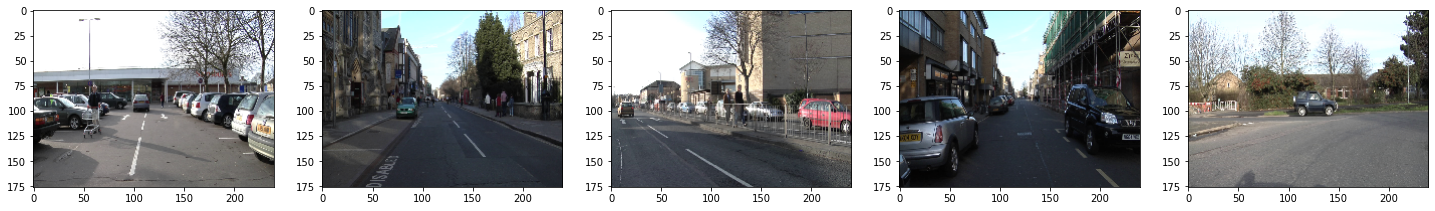

In [ ]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) 
for i in range(n):
  img = random.choice(train_images) # Случайное фото для отображения
  axs[i].imshow(img) 
plt.show() 

In [ ]:
train_segments=[]
val_segments=[]
cur_time=time.time()
for filename in sorted(os.listdir(directory+'/annotations_prepped_train')):
  train_segments.append(image.load_img(os.path.join(directory+'/annotations_prepped_train',filename),target_size=(img_width, img_height)))
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 
print ('Количество изображений: ', len(train_segments)) 

cur_time = time.time() 

for filename in sorted(os.listdir(directory+'/annotations_prepped_test')):                                              
    val_segments.append(image.load_img(os.path.join(directory+'/annotations_prepped_test',filename), 
                                     target_size=(img_width, img_height)))    
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') 
print ('Количество изображений: ', len(val_segments)) 

Обучающая выборка загржуена. Время загрузки: 0.96c
Количество изображений:  367
Проверочная выборка загржуена. Время загрузки: 0.25c
Количество изображений:  101


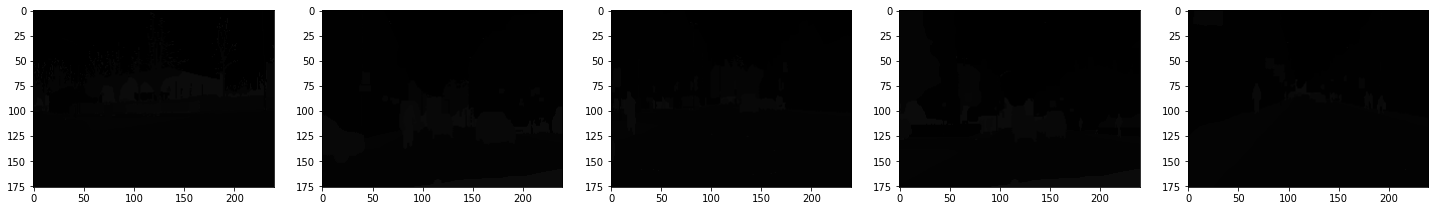

In [ ]:
n=5
fig,axs=plt.subplots(1,n,figsize=(25,5))
for i in range(n):
  img=random.choice(train_segments)
  axs[i].imshow(img)
plt.show()

In [ ]:
# Количество классов
num_classes=int(np.max(image.img_to_array(train_segments[0]))+1) # добавляем 1, так как подсчёт начинается с 0. Итого 12 классов
# num_classes=12
num_classes

12

In [ ]:
xTrain=np.array([image.img_to_array(train_images[i]) for i in range(len(train_images))])
xVal=np.array([image.img_to_array(val_images[i]) for i in range(len(val_images))])
yTrain=np.array([image.img_to_array(train_segments[i]) for i in range(len(train_segments))])
yVal=np.array([image.img_to_array(val_segments[i]) for i in range(len(val_segments))])

In [ ]:
print(xTrain.shape) # Размерность обучающей выборки
print(xVal.shape) # Размерность проверочной выборки
print(yTrain.shape) 
print(yVal.shape) 

(367, 176, 240, 3)
(101, 176, 240, 3)
(367, 176, 240, 3)
(101, 176, 240, 3)


In [ ]:
def rgbToohe(y, num_classes=num_classes): 
  """
  Функция перевода индекса пикселя в to_categorical
  """
  y2 = y.copy() 
  y = y.reshape(y.shape[0] * y.shape[1], 3) 
  yt = []
  for i in range(len(y)): 
    yt.append(utils.to_categorical(y[i][0], num_classes=num_classes)) 
  yt = np.array(yt) 
  yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes)
  return yt 

In [ ]:
yTrain_ohe=[rgbToohe(i) for i in yTrain]
yVal_ohe=[rgbToohe(i) for i in yVal]
yTrain_ohe=np.array(yTrain_ohe)
yVal_ohe=np.array(yVal_ohe)

In [ ]:
yTrain_ohe=[rgbToohe(i) for i in yTrain]
yVal_ohe=[rgbToohe(i) for i in yVal]
yTrain_ohe=np.array(yTrain_ohe)
yVal_ohe=np.array(yVal_ohe)

In [ ]:
# Цвета для каждого из 12 классов
my_colors=[(34,139,34), (128,0,0),   (255,0,255),   	(0,255,255),   (255,255,0),   (0,0,255),  
           (0,255,0),   (255,0,0),   (128,128,0),   (0,128,0),   (128,0,128),   (0,128,128) ]

In [ ]:
# Функция преобразования картинки сегментированной картики в цветную RGB
def repaint(image):
  image1=image.copy()
  for i in range((image1.shape[0])):
    for j in range(image1.shape[1]):
      for k in range(int(num_classes)):
        if int(image[i,j,0]) ==k:
          image1[i,j,0],image1[i,j,1],image1[i,j,2]=my_colors[k]
          break
  return image1


**Создание нейросети**

In [ ]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unet(num_classes = num_classes, input_shape= (176, 240, 3)):
    img_input = Input(input_shape)                                         

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) 
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         
    x = BatchNormalization()(x)                                            
    block_1_out = Activation('relu')(x)                                    

    x = MaxPooling2D()(block_1_out)                                       

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        
    x = BatchNormalization()(x)                                            
    block_2_out = Activation('relu')(x)                                    

    x = MaxPooling2D()(block_2_out)                                        

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)       
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        
    x = BatchNormalization()(x)                                            
    block_3_out = Activation('relu')(x)                                   

    x = MaxPooling2D()(block_3_out)                                        

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)       
    x = BatchNormalization()(x)                                            
    block_4_out = Activation('relu')(x)                                    
    x = block_4_out 

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = concatenate([x, block_3_out])                                      
    x = Conv2D(256, (3, 3), padding='same')(x)                             
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = concatenate([x, block_2_out])                                      
    x = Conv2D(128, (3, 3), padding='same')(x)                             
    x = BatchNormalization()(x)                                            
    x = Activation('relu')(x)                                              

    x = Conv2D(128, (3, 3), padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x) 

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x) 

    x = concatenate([x, block_1_out])  
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x) 

    x = Conv2D(64, (3, 3), padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x) 

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  

    model = Model(img_input, x) 
 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model 

In [ ]:
modelUnet = unet(num_classes, (img_width, img_height, 3))
modelUnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 176, 240, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 176, 240, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 176, 240, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 176, 240, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
modelUnet.save('/content/drive/My Drive/Базы/modelUnet.h5')

In [ ]:
EarlyStopping=EarlyStopping(monitor='val_dice_coef',mode='max',patience=5)

In [ ]:
def ModelCheckpoint_callback():
  return ModelCheckpoint(filepath='/content/drive/My Drive/Базы/model_checkpoint.h5',save_best_only=True,mode='max')

Epoch 1/45
12/12 [==============================] - 36s 3s/step - loss: 1.3961 - dice_coef: 0.4496 - val_loss: 13.4746 - val_dice_coef: 0.1659
Epoch 2/45
12/12 [==============================] - 25s 2s/step - loss: 0.8964 - dice_coef: 0.6088 - val_loss: 13.3730 - val_dice_coef: 0.1660
Epoch 3/45
12/12 [==============================] - 25s 2s/step - loss: 0.7567 - dice_coef: 0.6595 - val_loss: 13.2625 - val_dice_coef: 0.1650
Epoch 4/45
12/12 [==============================] - 25s 2s/step - loss: 0.6533 - dice_coef: 0.7083 - val_loss: 10.8764 - val_dice_coef: 0.2165
Epoch 5/45
12/12 [==============================] - 25s 2s/step - loss: 0.6067 - dice_coef: 0.7335 - val_loss: 5.8834 - val_dice_coef: 0.3457
Epoch 6/45
12/12 [==============================] - 25s 2s/step - loss: 0.5633 - dice_coef: 0.7501 - val_loss: 4.0750 - val_dice_coef: 0.4221
Epoch 7/45
12/12 [==============================] - 25s 2s/step - loss: 0.5349 - dice_coef: 0.7611 - val_loss: 1.8515 - val_dice_coef: 0.5304
Ep

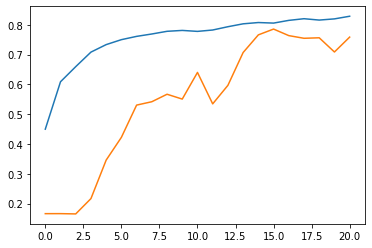

In [ ]:
history = modelUnet.fit(xTrain, yTrain_ohe, epochs=45,
                        batch_size=32, validation_data = (xVal, yVal_ohe),
                        callbacks=[EarlyStopping,ModelCheckpoint_callback()]
                        ) # Обучаем модель на выборке по трем классам
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()
modelUnet.save('/content/drive/My Drive/Базы/modelUnet1.h5')

**Визуализация результатов**

In [ ]:
def index2color(index2):
  """
  Функция преобразования индекса в цвет пикселя
  """
  index = np.argmax(index2) 
  color=my_colors[index]

  return color 

In [ ]:
def ohe2image(pred_img):
  """
  Функция преобразования предсказанного изображения в цветное
  """  
  image=np.zeros((img_width, img_height, 3))
  for i in range((image.shape[0])):
   for j in range(image.shape[1]):
     image[i,j,0],image[i,j,1],image[i,j,2]=index2color(pred_img[0][i][j])[0],index2color(pred_img[0][i][j])[1],index2color(pred_img[0][i][j])[2]
  return image

In [ ]:
def processImage(model, count = 5, n_classes = num_classes):
  """
  Функция визуализации сегментированных изображений
  """
  indexes = np.random.randint(0, len(xVal), count) 
  fig, axs = plt.subplots(3, count, figsize=(12, 12)) 
  for i,idx in enumerate(indexes): 
    predict = model.predict(xVal[idx].reshape(1, img_width, img_height, 3)) 
    axs[0,i].imshow(image.array_to_img(ohe2image(predict))) # Верхняя строка - предсказанное изображение
    axs[1,i].imshow(image.array_to_img(repaint(yVal[idx]))) #Средняя строка - сегментированное изображение
    axs[2,i].imshow(image.array_to_img(xVal[idx]))  #   Нижняя строка - оригинальное изображение  
  plt.show() 

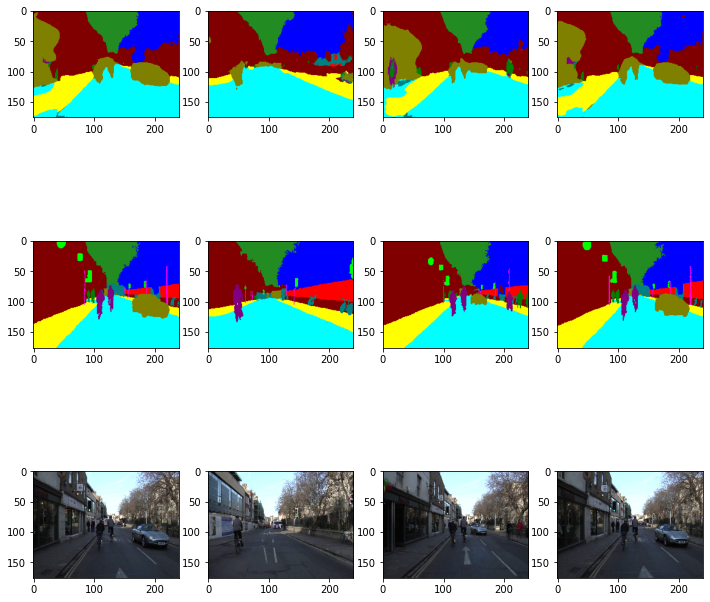

In [ ]:
processImage(modelUnet, 4, num_classes)

Из результатов видно, что модель не смогла распознать людей. Требуется дообучение модели

**Дообучение модели**

Epoch 1/30
12/12 [==============================] - 27s 2s/step - loss: 0.3623 - dice_coef: 0.8324 - val_loss: 0.6791 - val_dice_coef: 0.7426
Epoch 2/30
12/12 [==============================] - 27s 2s/step - loss: 0.3482 - dice_coef: 0.8373 - val_loss: 0.7682 - val_dice_coef: 0.7342
Epoch 3/30
12/12 [==============================] - 25s 2s/step - loss: 0.3330 - dice_coef: 0.8442 - val_loss: 0.6071 - val_dice_coef: 0.7592
Epoch 4/30
12/12 [==============================] - 25s 2s/step - loss: 0.3311 - dice_coef: 0.8443 - val_loss: 0.6616 - val_dice_coef: 0.7811
Epoch 5/30
12/12 [==============================] - 25s 2s/step - loss: 0.3336 - dice_coef: 0.8438 - val_loss: 0.5205 - val_dice_coef: 0.8158
Epoch 6/30
12/12 [==============================] - 25s 2s/step - loss: 0.3183 - dice_coef: 0.8502 - val_loss: 0.4394 - val_dice_coef: 0.8099
Epoch 7/30
12/12 [==============================] - 25s 2s/step - loss: 0.3134 - dice_coef: 0.8528 - val_loss: 0.5096 - val_dice_coef: 0.8115
Epoch 

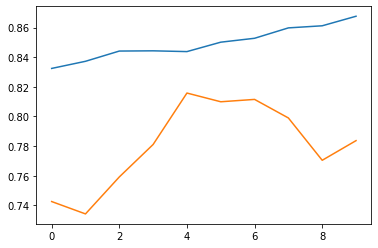

In [ ]:
history = modelUnet.fit(xTrain, yTrain_ohe, epochs=30,
                        batch_size=32, validation_data = (xVal, yVal_ohe),
                        callbacks=[EarlyStopping,ModelCheckpoint_callback()]
                        ) # Обучаем модель на выборке по трем классам
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

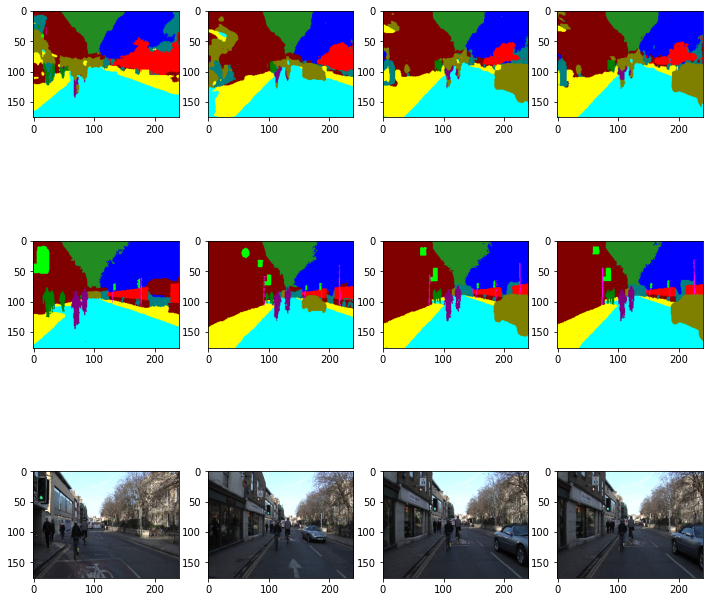

In [ ]:
processImage(modelUnet, 4, num_classes)

Epoch 1/30
12/12 [==============================] - 27s 2s/step - loss: 0.2756 - dice_coef: 0.8684 - val_loss: 0.6164 - val_dice_coef: 0.7812
Epoch 2/30
12/12 [==============================] - 25s 2s/step - loss: 0.2813 - dice_coef: 0.8658 - val_loss: 0.4699 - val_dice_coef: 0.8172
Epoch 3/30
12/12 [==============================] - 25s 2s/step - loss: 0.2646 - dice_coef: 0.8715 - val_loss: 0.4603 - val_dice_coef: 0.8314
Epoch 4/30
12/12 [==============================] - 25s 2s/step - loss: 0.2820 - dice_coef: 0.8673 - val_loss: 0.5079 - val_dice_coef: 0.8113
Epoch 5/30
12/12 [==============================] - 25s 2s/step - loss: 0.2741 - dice_coef: 0.8686 - val_loss: 0.5124 - val_dice_coef: 0.8285
Epoch 6/30
12/12 [==============================] - 25s 2s/step - loss: 0.2688 - dice_coef: 0.8699 - val_loss: 0.4659 - val_dice_coef: 0.8151
Epoch 7/30
12/12 [==============================] - 25s 2s/step - loss: 0.2507 - dice_coef: 0.8790 - val_loss: 0.4857 - val_dice_coef: 0.8036
Epoch 

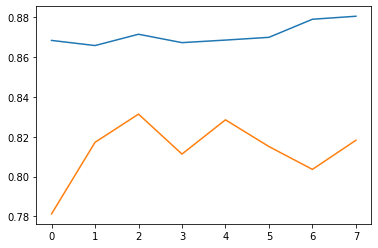

In [ ]:
history = modelUnet.fit(xTrain, yTrain_ohe, epochs=30,
                        batch_size=32, validation_data = (xVal, yVal_ohe),
                        callbacks=[EarlyStopping,ModelCheckpoint_callback()]
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

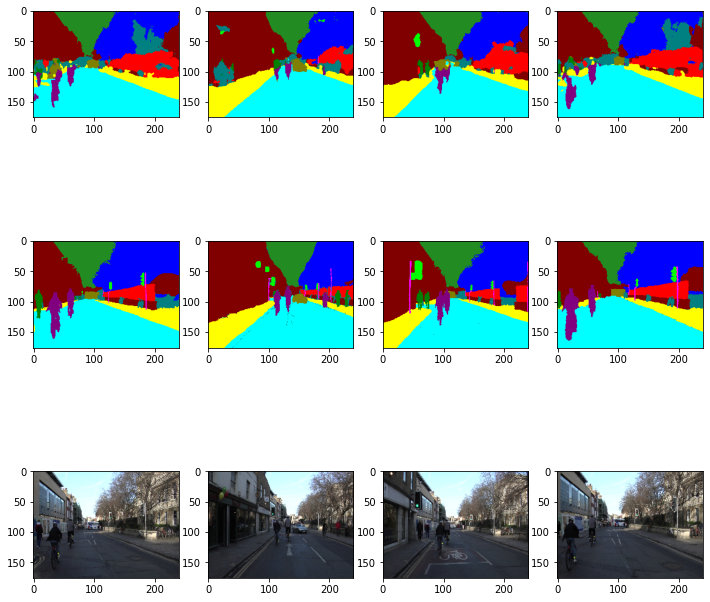

In [ ]:
processImage(modelUnet, 4, num_classes)

В результате дообучения модели сеть также научилась распознавать людей